In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

In [2]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_predict, GridSearchCV, cross_val_score, RepeatedStratifiedKFold, cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import make_scorer
from sklearn.metrics import fbeta_score
from sklego.metrics import p_percent_score
from statistics import mean
from sklego.metrics import equal_opportunity_score

In [3]:
from sklego.preprocessing import InformationFilter
from sklearn.model_selection import RandomizedSearchCV

In [4]:
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.feature_selection import RFE
from sklego.linear_model import DemographicParityClassifier
from sklego.linear_model import EqualOpportunityClassifier

In [5]:
import os
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [6]:
# protected attribute: gender
cols = ["age", "workclass", "fnlwgt", "education", "educational-num", "marital-status", "occupation", "relationship", "race", "gender", "capital-gain", "capital-loss", "hours-per-week", "native-country", "income"]

In [7]:
# load data
df_orig = pd.read_csv("/Users/jobo/Desktop/WellsFargo/adult.csv.zip", header=0, delimiter=',')

In [8]:
df_orig.head(10)

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K
5,34,Private,198693,10th,6,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States,<=50K
6,29,?,227026,HS-grad,9,Never-married,?,Unmarried,Black,Male,0,0,40,United-States,<=50K
7,63,Self-emp-not-inc,104626,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,3103,0,32,United-States,>50K
8,24,Private,369667,Some-college,10,Never-married,Other-service,Unmarried,White,Female,0,0,40,United-States,<=50K
9,55,Private,104996,7th-8th,4,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,10,United-States,<=50K


In [9]:
df_orig.shape

(48842, 15)

In [10]:
num_features = ['age', 'fnlwgt', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week']

In [11]:
cat_features = ['workclass', 'marital-status', 'occupation', 'relationship', 'native-country', 'race']

## Data Cleaning

### Handling Missing Data

In [12]:
# format of missing data:
question_mark = df_orig.loc[4, 'workclass']

In [13]:
# find features that have missing data
features_missing_data = {}
indices_missing_data = []
for index, row in df_orig.iterrows():
    for col in cols:
        if row[col] == question_mark:
            indices_missing_data.append(index)
            if col in features_missing_data:
                features_missing_data[col] += 1
            else:
                features_missing_data[col] = 1

In [14]:
# nativecountry, workclass, and occupation are the 3 features that contain missing data
features_missing_data

{'workclass': 2799, 'occupation': 2809, 'native-country': 857}

In [15]:
len(set(indices_missing_data))

3620

In [16]:
# check what percentage of rows have missing data
percent_rows_missing_data = len(set(indices_missing_data))/df_orig.shape[0]
percent_rows_missing_data

0.07411653904426518

Note: ~7% of the rows having missing data. Three main options come to mind for how to handle this missing data:
1. Remove missing data 
2. Replace missing data with most frequent values from that column (given that all three features with missing data are categorical)
3. Replace missing data such that the distribution of the missing dataset closely resembles the distribution of the non-missing dataset

Lets check how the distributions of gender and income in the missing data compare to that of the original data

In [17]:
indices_missing_unique = list(set(indices_missing_data))

In [18]:
df_missing_data = df_orig.iloc[indices_missing_unique]

### Distribution of gender in missing dataset

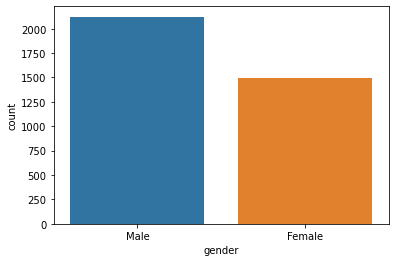

In [19]:
sns.countplot(x="gender", data= df_missing_data)
plt.show()

### Distribution of gender in original dataset

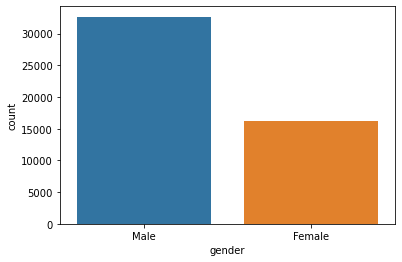

In [20]:
sns.countplot(x="gender", data= df_orig)
plt.show()

### Distribution of income in missing dataset

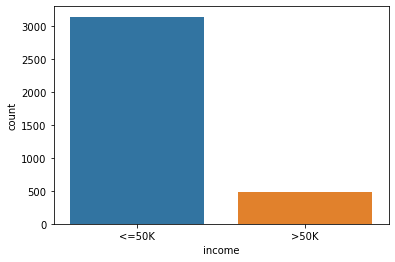

In [21]:
sns.countplot(x="income", data= df_missing_data)
plt.show()

### Distribution of income in original dataset

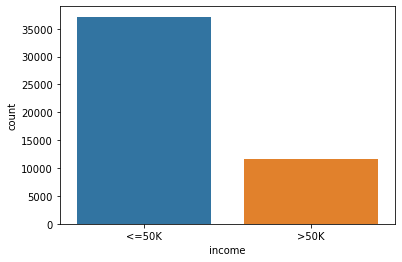

In [22]:
sns.countplot(x="income", data= df_orig)
plt.show()

The distribution of the gender and income in the missing datasets are similar enough to the respective distributions of the original dataset. For this reason, as well as the fact that a relatively small portion of the rows have missing values (~7%), I will remove the rows with missing data.

In [23]:
# make copy of original df so that further tranformations won't change original df
df_transformed = df_orig.copy()
# remove rows which contain missing data
df_transformed = df_transformed.drop(df_transformed[df_transformed.workclass == question_mark].index)
df_transformed = df_transformed.drop(df_transformed[df_transformed.occupation == question_mark].index)
df_transformed = df_transformed.drop(df_transformed[df_transformed["native-country"] == question_mark].index)

In [24]:
df_transformed.shape

(45222, 15)

## Feature Engineering

In [25]:
df_transformed['education'].value_counts()

HS-grad         14783
Some-college     9899
Bachelors        7570
Masters          2514
Assoc-voc        1959
11th             1619
Assoc-acdm       1507
10th             1223
7th-8th           823
Prof-school       785
9th               676
12th              577
Doctorate         544
5th-6th           449
1st-4th           222
Preschool          72
Name: education, dtype: int64

In [26]:
df_transformed['educational-num'].value_counts()

9     14783
10     9899
13     7570
14     2514
11     1959
7      1619
12     1507
6      1223
4       823
15      785
5       676
8       577
16      544
3       449
2       222
1        72
Name: educational-num, dtype: int64

Educational number and education are essentially providing the same information. For this reason, and remove education. I choose to remove education because I would rather have a continuous variable than a categorical variable with many values that I would need one-hot encoding.

In [27]:
# remove education feature
df_transformed = df_transformed.drop('education', 1)

### Marital-Status

In [28]:
df_transformed['marital-status'].value_counts()

Married-civ-spouse       21055
Never-married            14598
Divorced                  6297
Separated                 1411
Widowed                   1277
Married-spouse-absent      552
Married-AF-spouse           32
Name: marital-status, dtype: int64

In order to make one-hot encoding simpler, I will condense marital-status into the following 4 categories:
1. married ( Married-civ-spouse, Married-spouse-absent, Married-AF-spouse)
2. separated (Divorced, Separated)
3. never-married
4. widowed

In [29]:
married= ['Married-civ-spouse','Married-spouse-absent','Married-AF-spouse']
separated  = ['Divorced', 'Separated']

df_transformed['marital-status'].replace(to_replace = married ,value = 'Married',inplace = True)
df_transformed['marital-status'].replace(to_replace = separated,value = 'Separated',inplace = True)

In [30]:
df_transformed['marital-status'].value_counts()

Married          21639
Never-married    14598
Separated         7708
Widowed           1277
Name: marital-status, dtype: int64

### Workclass

In [31]:
df_transformed['workclass'].value_counts()

Private             33307
Self-emp-not-inc     3796
Local-gov            3100
State-gov            1946
Self-emp-inc         1646
Federal-gov          1406
Without-pay            21
Name: workclass, dtype: int64

I will condense workclass into the following 4 categories:
1. Self-employed (Self-emp-not-inc, Self-emp-inc)
2. Government (Local-gov, State-gov, Federal-gov)
3. Private
4. Without-pay

In [32]:
self_employed = ['Self-emp-not-inc','Self-emp-inc']
government_employees = ['Local-gov','State-gov','Federal-gov']

df_transformed['workclass'].replace(to_replace = self_employed ,value = 'Self_employed',inplace = True)
df_transformed['workclass'].replace(to_replace = government_employees,value = 'Govt_employees',inplace = True)

In [33]:
df_transformed['workclass'].value_counts()

Private           33307
Govt_employees     6452
Self_employed      5442
Without-pay          21
Name: workclass, dtype: int64

### Native country

In [34]:
len(df_transformed['native-country'].value_counts())

41

Given that each country outside of US accounts for less than 2% of the dataset, I will condense these category into the following 2 categories:
1. US
2. Not US

In [35]:
not_us = []
for country in df_transformed['native-country'].unique():
    if country != 'United-States':
        not_us.append(country)
df_transformed['native-country'].replace(to_replace = not_us ,value = 'Not United-States',inplace = True)

In [36]:
df_transformed['native-country'].value_counts()

United-States        41292
Not United-States     3930
Name: native-country, dtype: int64

In [37]:
# convert categorical variables into numerical variables through one-hot encoding
df_transformed = pd.get_dummies(df_transformed, columns = cat_features)

In [38]:
# convert gender into a binary column
df_transformed['gender'] = LabelEncoder().fit_transform(df_transformed['gender'])
# convert income label into a binary column
df_transformed['income'] = LabelEncoder().fit_transform(df_transformed['income'])

In [39]:
# scale numerical data
df_transformed[num_features] = StandardScaler().fit_transform(df_transformed[num_features])

In [40]:
x = df_transformed.drop('income', axis = 1)

In [41]:
y = df_transformed.income

In [42]:
# used to compute p_percent_score
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = 0.2, random_state = 0)

# Initital Modeling

To begin our model experiments, we used the Logistic Regression classifier from scikit-learn to build our initial model without a fairness constraint. Next, in order to follow the demographic parity measure of fairness to build a model with a fairness constraint, we used the Demographic Parity Classifier from the scikit-lego python module. This classifier is built as an extension of basic logistic regression with the addition of a fairness constraint applied to protected variable(s).  That is, scikit-lego's Demographic Parity Classifier maps feature vectors $x_i$ to class labels $y_i$ using the same probability distribution as logisitic regression:
\begin{gather}
\operatorname{P}(y_i=1|x_i,\theta) = \frac{1}{1+e^{-\theta^Tx_i}}
\end{gather}
Furthermore, $\theta$, the estimated parameter vector, is obtained using Maximum Likelihood Estimation, just as with logistic regression:
\begin{gather}
\operatorname{arg,min}_\theta = -\sum_{i=1}^N \log\ \operatorname{P}(y_i|x_i, \theta)
\end{gather}
The only difference is that the Demographic Parity Classifier adds the following constraint to the above optimization problem. 
\begin{gather}
\text{minimize}\ -\sum_{i=1}^N \log\ \operatorname{P}(y_i|x_i, \theta) \\
\text{subject to}\  \operatorname{Cov}(z, d_\theta(x)) \leq c \\
\operatorname{Cov}(z, d_\theta(x))  \geq -c
\end{gather}

% $$\text{subject to}\  \frac{1}{N} \sum_{i=1}^N (z_i - \overline{z})\theta^T x_i \leq c,  \frac{1}{N} \sum_{i=1}^N (z_i - \overline{z})\theta^T x_i \geq -c$$
Where $z$ is the protected variable, and $d_\theta(x)$ is the signed distance from feature vectors to the decision boundary. Furthermore, $c$ is a covariance threshold, ranging from 0 to 1, specifying a limit for accepted covariance between protected variable and signed distance from feature vectors to the decision boundary. 

In [43]:
# classifiers
classifiers=['Logistic Regression clf', 'Demographic Parity clf (covariance thrshold = 0)']

In [44]:
models=[LogisticRegression(max_iter=5000),DemographicParityClassifier(sensitive_cols=['gender'], covariance_threshold=0.0000069)]

In [45]:
# define cross-validation procedure
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

In [46]:
# model evaluation metrics 
mean_accuracy=[]
mean_precision=[]
mean_recall=[]
accuracy_std=[]
p_percents_sex=[]

In [47]:
for model in models:
    # accuracy
    cv_accuracy = cross_val_score(model,x,y,scoring = "accuracy", cv = cv, n_jobs=-1)
    # precision
    cv_precision = cross_val_score(model, x, y, scoring='precision', cv=cv, n_jobs=-1)
    # recall
    cv_recall = cross_val_score(model, x, y, scoring='recall', cv=cv, n_jobs=-1)
    #p% 
    model.fit(xtrain, ytrain)
    p_percent_sex = p_percent_score(sensitive_column="gender")(model, xtest, ytest)
    
    mean_accuracy.append(mean(cv_accuracy))
    accuracy_std.append(cv_accuracy.std())
    mean_precision.append(mean(cv_precision))
    mean_recall.append(mean(cv_recall))
    p_percents_sex.append(p_percent_sex)

In [48]:
models_dataframe=pd.DataFrame({'Mean Accuracy':mean_accuracy, 'Accuracy Std':accuracy_std, 'Mean Precision':mean_precision, 'Mean Recall':mean_recall,  'P%':p_percents_sex},index=classifiers)

## Benchmark results

In [56]:
df_transformed['gender'].value_counts()

1    30527
0    14695
Name: gender, dtype: int64

In [50]:
df_transformed.groupby(['gender','income']).size()

gender  income
0       0         13026
        1          1669
1       0         20988
        1          9539
dtype: int64

In [52]:
df_transformed['income'].value_counts()

0    34014
1    11208
Name: income, dtype: int64

In [54]:
len(df_transformed)

45222

Baseline comparison for p percentage relative to gender: if our model was 100% accurate, the following would be our p percent score for gender:

In [55]:
# positive outcome female / total female
p_y1_z0 = 1669/14695
# positive outcome male / total male 
p_y1_z1 = 9539/30527
dataset_p_percent = np.minimum(p_y1_z1 / p_y1_z0, p_y1_z0 / p_y1_z1)
dataset_p_percent

0.3634695423643793

Baseline comparison for accuracy: if our model only predicted <= 50K (majority outcome class), our accuracy would be 34014/45222 = 0.752

In [57]:
baseline_dataframe = pd.DataFrame({'Baseline accuracy': [0.752], 'Baseline p%': [0.3635]}, index=['Baseline'])
baseline_dataframe

,Baseline accuracy,Baseline p%
Baseline,0.752,0.3635


In [58]:
models_dataframe

,Mean Accuracy,Accuracy Std,Mean Precision,Mean Recall,P%
Logistic Regression clf,0.847117,0.00327,0.733321,0.602248,0.294822
Demographic Parity clf (covariance thrshold = 0),0.831697,0.00300,0.726867,0.514246,0.775931


## Exploration of Covariance Threshold Hyperparameter for Demographic Parity Classifier

In [59]:
dpc_clf = DemographicParityClassifier(sensitive_cols="gender", covariance_threshold=0.5)

In [60]:
grid_dpc = GridSearchCV(estimator=dpc_clf, param_grid={"estimator__covariance_threshold":np.linspace(0, 1, 40)}, cv=5, return_train_score=True, refit="p_percent_score", scoring={"p_percent_score":p_percent_score('gender'), "accuracy_score":make_scorer(accuracy_score)})

In [61]:
grid_dpc.fit(x,y)

GridSearchCV(cv=5,
             estimator=OneVsRestClassifier(estimator=_DemographicParityClassifier(covariance_threshold=0.5,
                                                                                  sensitive_cols='gender'),
                                           n_jobs=1),
             param_grid={'estimator__covariance_threshold': array([0.        , 0.02564103, 0.05128205, 0.07692308, 0.1025641 ,
       0.12820513, 0.15384615, 0.17948718, 0.20512821, 0.23076923,
       0.25641026, 0.28205128, 0.30769231, 0.33333333, 0.358...
       0.51282051, 0.53846154, 0.56410256, 0.58974359, 0.61538462,
       0.64102564, 0.66666667, 0.69230769, 0.71794872, 0.74358974,
       0.76923077, 0.79487179, 0.82051282, 0.84615385, 0.87179487,
       0.8974359 , 0.92307692, 0.94871795, 0.97435897, 1.        ])},
             refit='p_percent_score', return_train_score=True,
             scoring={'accuracy_score': make_scorer(accuracy_score),
                      'p_percent_score': <function

In [62]:
results_dpc = (pd.DataFrame(grid_dpc.cv_results_).set_index("param_estimator__covariance_threshold"))

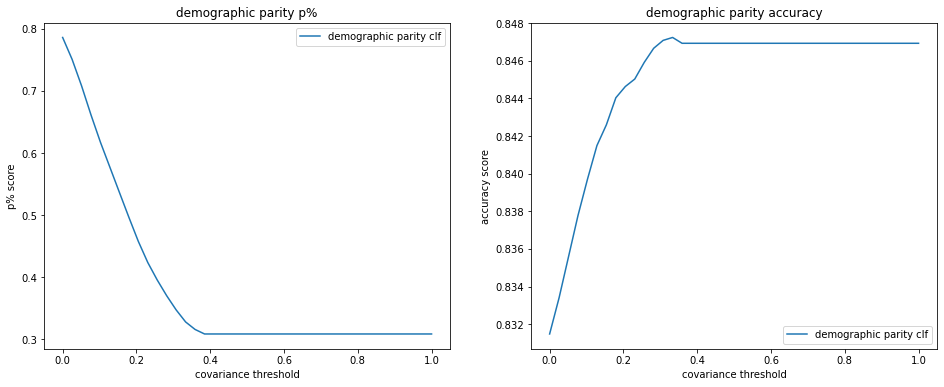

In [63]:
plt.figure(figsize=(16,6))
plt.subplot(121)
plt.plot(np.array(results_dpc.index), results_dpc['mean_test_p_percent_score'], label='demographic parity clf')
plt.xlabel("covariance threshold")
plt.ylabel('p% score')
plt.legend()
plt.title("demographic parity p%")
plt.subplot(122)
plt.plot(np.array(results_dpc.index), results_dpc['mean_test_accuracy_score'], label='demographic parity clf')
plt.xlabel("covariance threshold")
plt.ylabel('accuracy score')
plt.legend()
plt.title("demographic parity accuracy");

## Approach 1:  Exploring how feature importance changes as a function of p% (fairness score) for gender 
### (measuring feature importance as abs(feature weight) * average absolute value of that feature's column)

In this approach to identifying each feature's contribution to fairness violations, we will leverage the above relationship between covariance threshold and p% in order to plot out how magnitude of a feature's 'influence' on outcome predictions changes relative to p%. It's important to note that we are measuring how much 'influence' a feature has on the outcome predictions by multiplying the absolute value of a feature's learned coefficient by the average absolute value of that feature's column. That is, we are not taking the sign of the coefficient into consideration, rather, we are measuring the overall magnitude of a feature's 'influence' on outcome predictions without considering whether that feature's influence is pushing the classification towards the positive outcome or the negative outcome. Furthermore, the reason for multiplying the learned coefficient by the average absolute value is to account for the fact that feature's that are binary variables will require a larger coefficient than feature's with a large range of values in order to have the same influence on the final outcome. That is, multiplying the learned coefficient by the average absolute value makes the 'influence' of binary variables and variables with greater ranges of values more comparable.

NOTE: we will be referring to this measure of a feature's 'influence' on outcome predictions as 'feature importance' for the duration of this approach.

We will accomplsih this approach by training 40 different demographic parity classifier models, each with a different covariance thresholds between 0-0.4 (we see fairness flatlines slightly before a cov threshold of 0.4) in order to achieve a wide range of fairness scores. We will then plot out how 'feature importance' changes as a function of fairness.


In [64]:
# The specified sensitive column of a demographic parity classifier does not receive a coefficient during training,
# therefore, our features for the demographic parity classfier will exclude our protected variable, gender.
dpc_features = x.columns.drop('gender')

In [65]:
# create dictionary where keys are features, and values are an empty list (to be populated later on)
feature_dict = {}
for feat in dpc_features:
    feature_dict[feat] = []

In [66]:
# covariance thresholds we will be using to train our demographic parity classifier models
cov_threshold = np.linspace(0,0.4,40)

In [69]:
# build demographic parity models with 40 different covariance thresholds, storing each corresponding
# feature importance in the above dictionary, allowing us to see how each feature's importance changes 
# as a function of p% 
for cov in cov_threshold:
    model = DemographicParityClassifier(sensitive_cols="gender", covariance_threshold=cov)
    # fit on training split
    model.fit(xtrain, ytrain)
    # test p percent on testing split
    p_percent = p_percent_score(sensitive_column="gender")(model, xtest, ytest)
    for coef, feat in zip(model.coef_[0,:],dpc_features):
        feature_dict[feat].append([cov,abs(coef)*abs(df_transformed[feat]).mean(),p_percent])

In [75]:
# format = {'feature x': [covariance threshold, feature x importance, p_percent]}
# example:
feature_dict['relationship_Husband'][0]

[0.0, 0.06332831018839989, 0.7759308977739477]

Now that we have the feature importance and p% score for all 40 dpc models, we will plot out how each feature's importance changes between minimal and maximal p% (feature importance at maximal fairness - feature importance at minimal fairness).

In [72]:
df_list = []
delta_list = []
for feature in feature_dict:
    df_ = pd.DataFrame(data = feature_dict[feature], columns = ["cov", f"{feature}_importance", "p percent"])
    df_.sort_values('p percent')
    df_ = df_.reset_index(drop=True)
    most_fair = df_.at[0,f"{feature}_importance"]
    least_fair = df_.at[39, f"{feature}_importance"]
    #change in feature importance between minimal and maximal p%
    fairness_delta = most_fair - least_fair
    delta_list.append(fairness_delta)    
feature_fairness_delta = list(zip(feature_dict.keys(),delta_list))
feature_fairness_delta_sort = sorted(feature_fairness_delta, key=lambda x : x[1])

features = []
delta_importance = []
for item in feature_fairness_delta_sort:
    features.append(item[0])
    delta_importance.append(item[1])

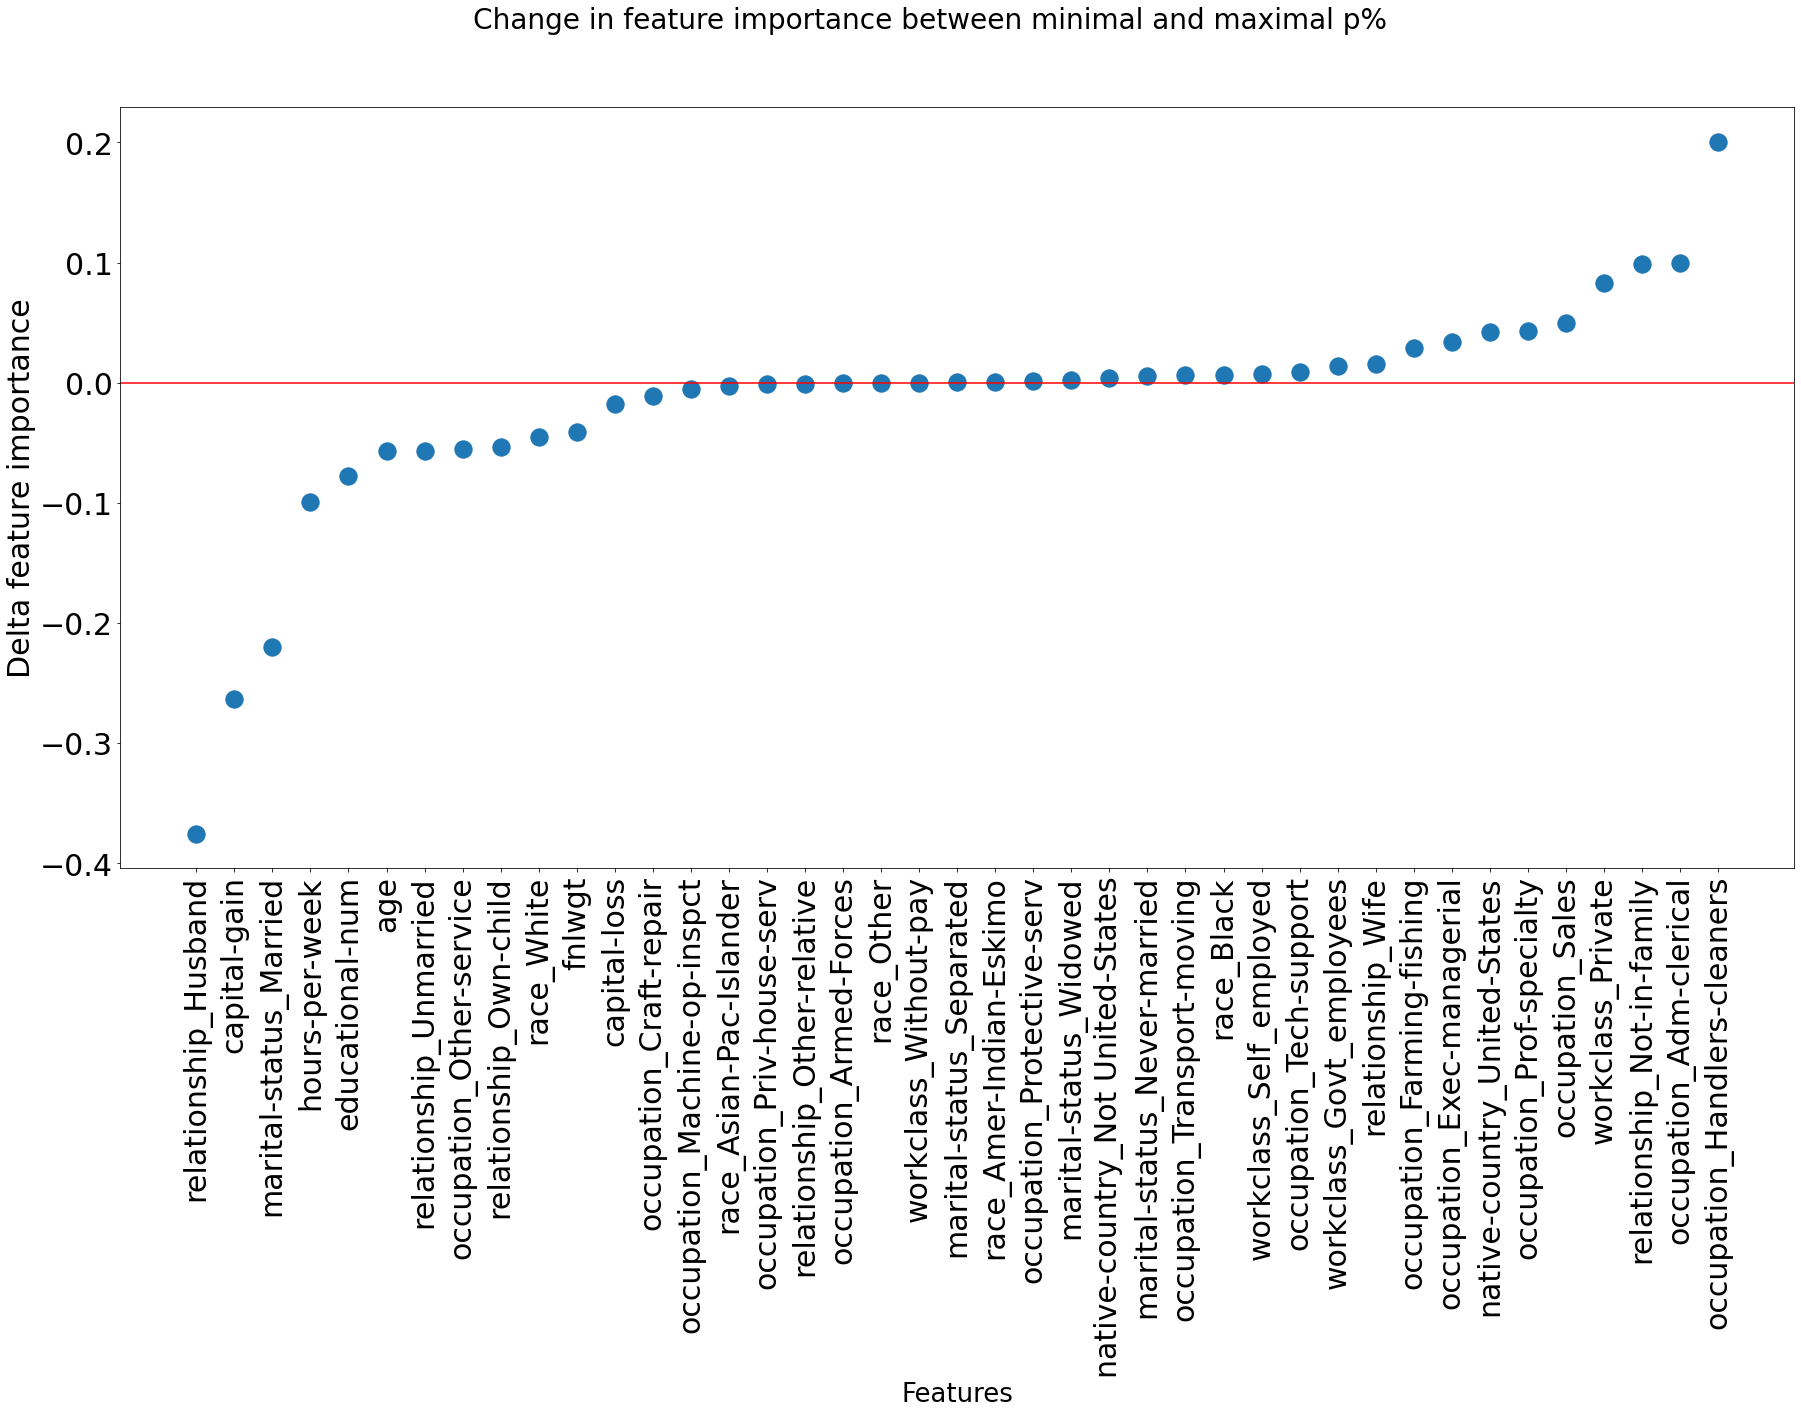

In [76]:
figure, ax = plt.subplots(figsize=(30,14))
ax.scatter(features, delta_importance, s=300)
xticks_labels = features
ax.set_xticklabels(xticks_labels, rotation=90, fontsize=30)
figure.suptitle('Change in feature importance between minimal and maximal p%', fontsize=28)
plt.xlabel("Features", fontsize=26)
plt.ylabel('Delta feature importance', fontsize=30)
plt.yticks(fontsize=30)
ax.axhline(y=0, color="red")
plt.show()

We see that relationship_Husband, capital-gain, marital-status_Married, hours-per-week, and educational-num are the five features whose magnitude of feature importance exhibited the greatest decrease relative to p%. Below is a plot of exactly how these five feature's importance changed as a function of p%.

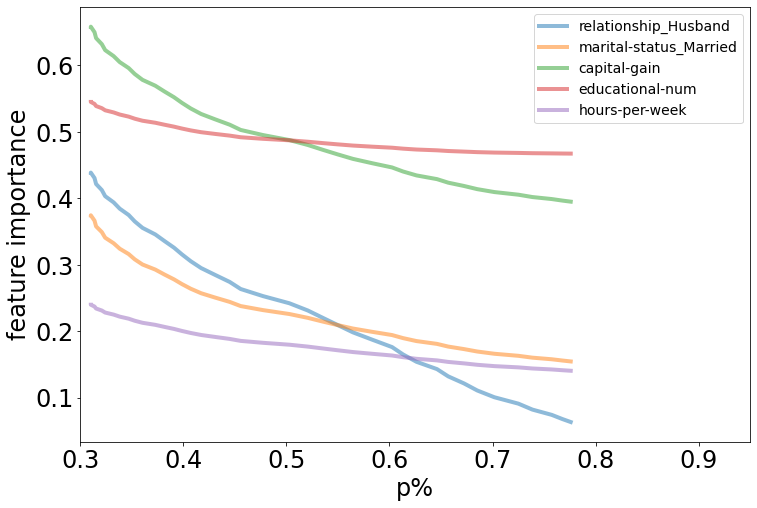

In [77]:
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(12,8))

for feature in ['relationship_Husband', 'marital-status_Married','capital-gain', 'educational-num', 'hours-per-week']:
    xs = [x[2] for x in feature_dict[feature]]
    ys = [x[1] for x in feature_dict[feature]]
    ax.plot(xs,ys,alpha=0.5, label=feature, linewidth=4)

plt.xlabel("p%")
plt.ylabel('Feature Importance', fontsize=20)
plt.yticks(fontsize=24)
plt.xticks(fontsize=24)
plt.xlim((0.3, 0.95))
ax.legend(prop={'size':14})
ax.set_xlabel("p%", fontsize=24)
ax.set_ylabel("feature importance", fontsize=24)
ax.tick_params(labelbottom=True)

This plot shows that the magnitude of feature influence on predicted outcome for Relationship:Husband, Marital-status:Married, Capital-gain, Education number, and Hours-per-week all decreased measurably as $p\%$ increased. Given that $p\%$ is increasing as magnitude of feature influence is decreasing, we can interpret these features as the 5 features that contribute the most to fairness violations.

The specific decrease in magnitude of feature influence from lowest $p\%$ to greatest $p\%$ for the above features is plotted below.

In [78]:
# creating a pandas df for each feature
df_list = []
delta_list = []
for feature in ['relationship_Husband', 'marital-status_Married','capital-gain', 'educational-num', 'hours-per-week']:
    df_ = pd.DataFrame(data = feature_dict[feature], columns = ["cov", f"{feature}_importance", "p percent"])
    df_.sort_values('p percent')
    df_ = df_.reset_index(drop=True)
    most_fair = df_.at[0,f"{feature}_importance"]
    least_fair = df_.at[39, f"{feature}_importance"]
    #fairness_delta = most_fair - least_fair
    fairness_delta = most_fair-least_fair
    delta_list.append(fairness_delta)    
feature_fairness_delta = list(zip(['relationship_Husband', 'marital-status_Married','capital-gain', 'educational-num', 'hours-per-week'],delta_list))
feature_fairness_delta_sort = sorted(feature_fairness_delta, key=lambda x : x[1])
#feature_fairness_delta_sort
features = []
delta_importance = []
for item in feature_fairness_delta_sort:
    features.append(item[0])
    delta_importance.append(item[1])

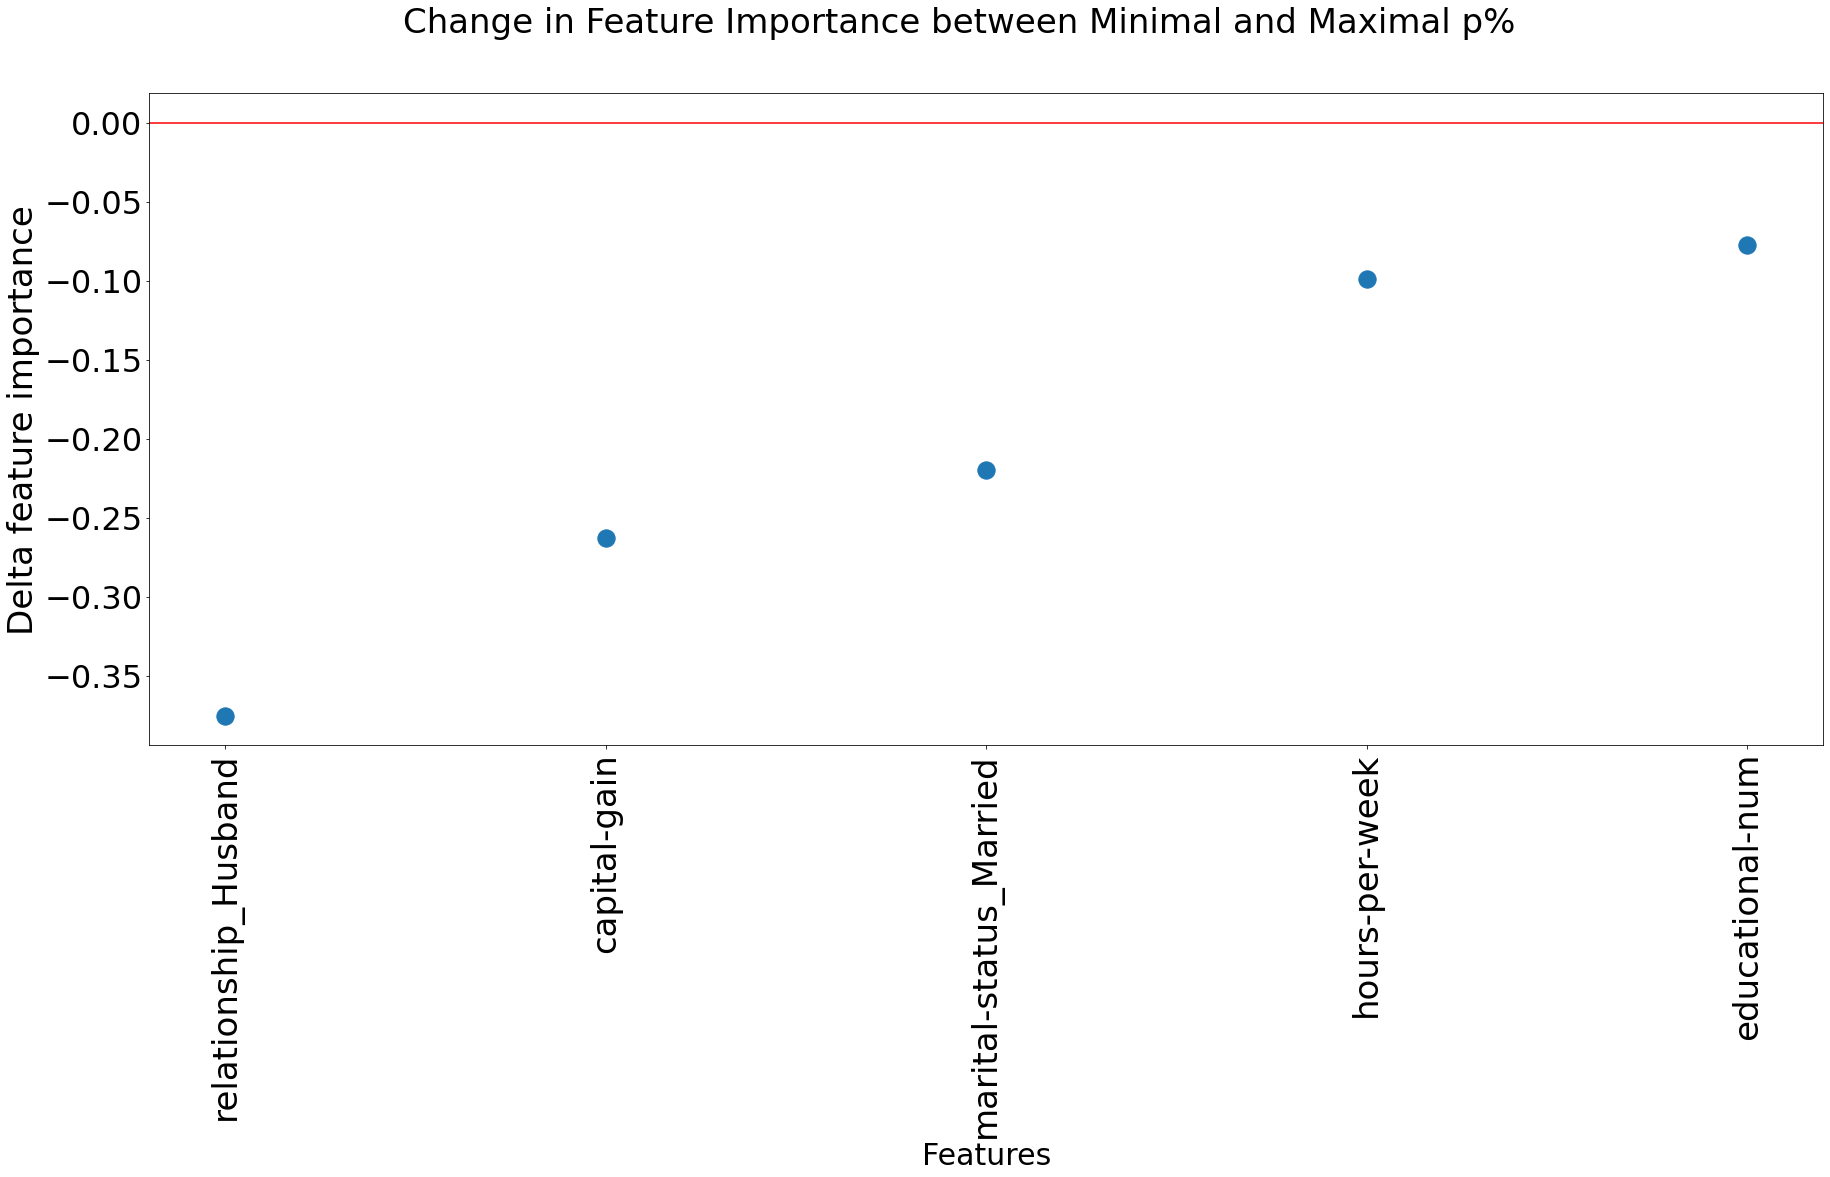

In [79]:
figure, ax = plt.subplots(figsize=(30,12))
ax.scatter(features, delta_importance, s=300)
xticks_labels = features
plt.yticks(fontsize=32)
ax.set_xticklabels(xticks_labels, rotation=90, fontsize=34)
figure.suptitle('Change in Feature Importance between Minimal and Maximal p%', fontsize=34)
plt.xlabel("Features", fontsize=30)
plt.ylabel('Delta feature importance', fontsize=34)
ax.axhline(y=0, color="red")
plt.show()

Considering the two figures above, this approach suggests that Relationship:Husband contributed the most to fairness violations, followed by Capital-gain, Marital-Status:Married, Hours-per-week, and education number, in that respective order. 

The following plot shows the top 3 features that exhibited the greatest increase in magnitude of feature influence relative to $p\%$:

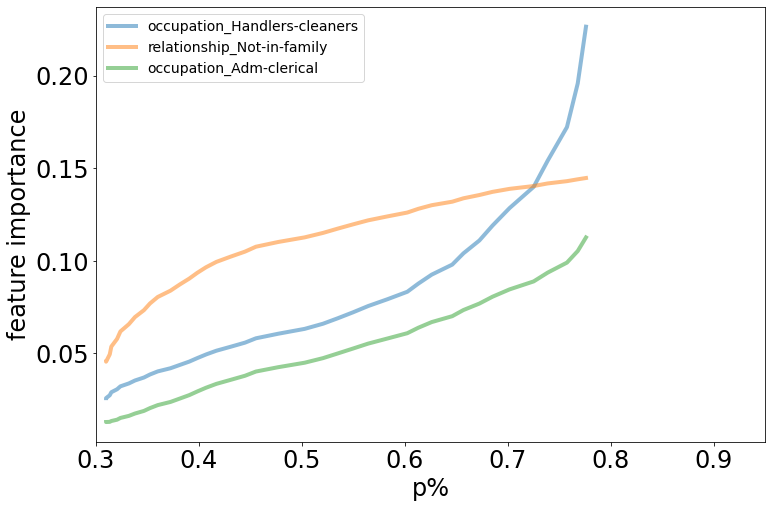

In [80]:
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(12,8))

for feature in ['occupation_Handlers-cleaners', 'relationship_Not-in-family', 'occupation_Adm-clerical']:
    xs = [x[2] for x in feature_dict[feature]]
    ys = [x[1] for x in feature_dict[feature]]
    ax.plot(xs,ys,alpha=0.5, label=feature, linewidth=4)

plt.xlabel("p%")
plt.ylabel('Feature Importance', fontsize=20)
plt.yticks(fontsize=24)
plt.xticks(fontsize=24)
plt.xlim((0.3, 0.95))
ax.legend(prop={'size':14})
ax.set_xlabel("p%", fontsize=24)
ax.set_ylabel("feature importance", fontsize=24)
ax.tick_params(labelbottom=True)

We see that the magnitude of feature influence on predicted outcome for Occupation:Handlers-cleaners, Relationship:Not-in-Family, and Occupation:Adm-clerical all increased as $p\%$ increased. Given that $p\%$ is increasing as magnitude of feature influence is increasing, we can interpret these features as the 3 features that contribute the most to reducing fairness violations.

The specific increase in magnitude of feature influence from lowest $p\%$ to greatest $p\%$ for the above features is plotted below.

In [81]:
# creating a pandas df for each feature
df_list = []
delta_list = []
for feature in ['occupation_Handlers-cleaners', 'relationship_Not-in-family', 'occupation_Adm-clerical']:
    df_ = pd.DataFrame(data = feature_dict[feature], columns = ["cov", f"{feature}_importance", "p percent"])
    df_.sort_values('p percent')
    df_ = df_.reset_index(drop=True)
    most_fair = df_.at[0,f"{feature}_importance"]
    least_fair = df_.at[39, f"{feature}_importance"]
    fairness_delta = abs(least_fair - most_fair)
    delta_list.append(fairness_delta)    
feature_fairness_delta = list(zip(['occupation_Handlers-cleaners', 'relationship_Not-in-family', 'occupation_Adm-clerical'],delta_list))
feature_fairness_delta_sort = sorted(feature_fairness_delta, key=lambda x : x[1])

features = []
delta_importance = []
for item in feature_fairness_delta_sort:
    features.append(item[0])
    delta_importance.append(item[1])

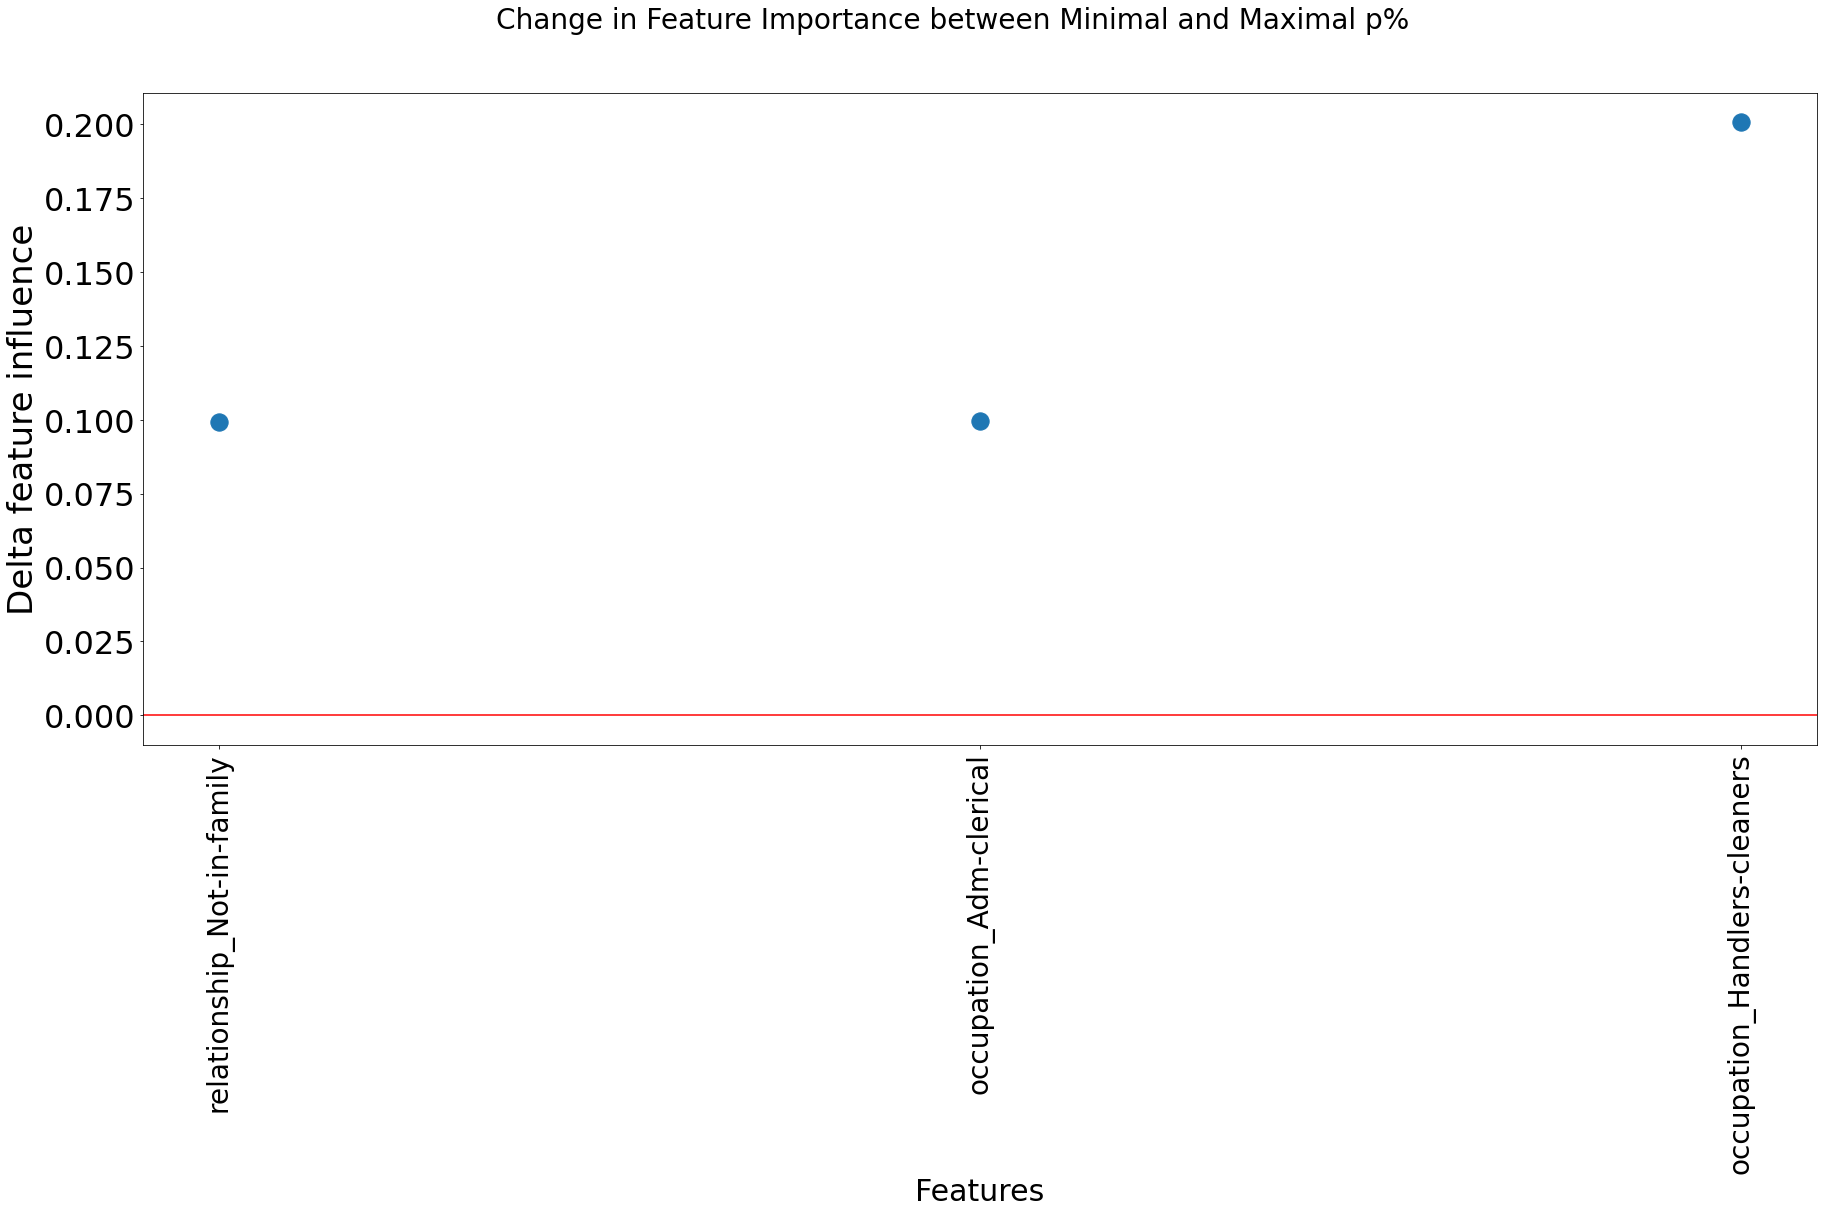

In [82]:
figure, ax = plt.subplots(figsize=(30,12))
ax.scatter(features, delta_importance, s=300)
xticks_labels = features
plt.yticks(fontsize=32)
ax.set_xticklabels(xticks_labels, rotation=90, fontsize=28)
figure.suptitle('Change in Feature Importance between Minimal and Maximal p%', fontsize=28)
plt.xlabel("Features", fontsize=30)
plt.ylabel('Delta feature influence', fontsize=34)
ax.axhline(y=0, color="red")
plt.show()

Considering the two figures above, approach 1 suggests that Occupation:Handlers-cleaners contributed the most to reducing fairness violations, followed by Occupation:Adm-clerical, and Relationship:Not-in-Family, in that respective order.

## Approach 2: Fairness Decomposition based on Model Difference Regression

As shown in the above benchmark results, we have two different logistic regression models which achieved measurably different $p\%$ scores relative the protected variable, gender. For the purposes of explaining this approach, we will refer to the logistic regression model without fairness constraint as the unfair model, and the logistic regression model with a maximal fairness constraint applied to gender (Demographic Parity Classifier with covariance threshold of 0) as the fair model.  Please note that 'fair' and 'unfair' are specifically referring to the demographic parity measure of fairness.

The goal of this approach was to build a decomposition model that models the difference between the fair model and the unfair model. We accomplished this by modeling the log odds of the fair model using the log odds of the unfair model and the original predictors from the data. That is, our decomposition model took the form of:


$$log\ odds_{fair} \sim log\ odds_{unfair} + \beta_0 + \beta_1\cdot x_1 + \beta_2\cdot x_2 + \cdots + \beta_n \cdot x_n$$
which is equivalent to:
$$log\ odds_{fair} - log\ odds_{unfair} \sim \beta_0 + \beta_1\cdot x_1 + \beta_2\cdot  x_2 + \cdots + \beta_n\cdot x_n$$


Because our decomposition model is modeling the difference between a fair model and an unfair model, we can use the learned coefficients of the decomposition model, factoring in the average difference in feature values between females and males, to evaluate which features were contributing the most to the difference in $p\%$ scores for the unfair and fair models. This evaluation metric took the following form:


x_1  :           $\beta_1$  *  [  Mean( $x_1$ | z = 0)  -  Mean(  $x_1$  | z = 1)  ]

x_2  :           $\beta_2$  *  [  Mean( $x_2$ | z = 0)  -  Mean(  $x_2$  | z = 1)  ]

...

x_n  :           $\beta_n$  *  [  Mean( $x_n$ | z = 0)  -  Mean(  $x_n$  | z = 1)  ]

where 
$\beta_i$ is the learned feature coefficient for feature $x_i$ in the decomposition model, and 
$z$ is the binary protected variable.

In [83]:
unfair_model = LogisticRegression(max_iter=5000)
fair_model = DemographicParityClassifier(sensitive_cols=['gender'], covariance_threshold=0.0000069)

In [96]:
# remove protected variable column (gender) prior to training for unfair model
x_decomp = x.drop('gender', axis=1)

In [85]:
unfair_model.fit(x_decomp,y)
fair_model.fit(x,y)

OneVsRestClassifier(estimator=_DemographicParityClassifier(covariance_threshold=6.9e-06,
                                                           sensitive_cols=['gender']),
                    n_jobs=1)

In [86]:
beta_transpose_unfair = np.transpose(unfair_model.coef_)
beta_transpose_fair = np.transpose(fair_model.coef_)

In [87]:
log_odds_unfair = x_decomp @ beta_transpose_unfair
log_odds_fair = x_decomp @ beta_transpose_fair

In [88]:
y_mod_diff = log_odds_fair - log_odds_unfair

In [89]:
model_difference = LinearRegression()

In [90]:
model_difference.fit(x_decomp, y_mod_diff)

LinearRegression()

In [91]:
feat_dict = {}
for feat in x_decomp.columns:
    feat_dict[feat] = []

In [92]:
for coef, feat in zip(model_difference.coef_[0,:], x_decomp.columns):
    # [Mean( x_n | z = 0) - Mean( x_n | z = 1)]
    mean_feat_given_class_diff = df_transformed[feat].loc[df_transformed['gender'] == 0].mean() - df_transformed[feat].loc[df_transformed['gender'] == 1].mean()
    feat_dict[feat].append(coef*mean_feat_given_class_diff)

In [93]:
mod_diff_df = pd.DataFrame.from_dict(feat_dict, orient='index', columns=['feature contribution'])
sorted_diff = mod_diff_df.sort_values(by=['feature contribution'], ascending=False)

In [94]:
sorted_diff

,feature contribution
relationship_Husband,0.536267
marital-status_Married,0.211026
occupation_Handlers-cleaners,0.163949
occupation_Adm-clerical,0.151832
occupation_Other-service,0.127946
relationship_Unmarried,0.116557
capital-gain,0.090657
hours-per-week,0.075087
relationship_Wife,0.055908
occupation_Craft-repair,0.038797


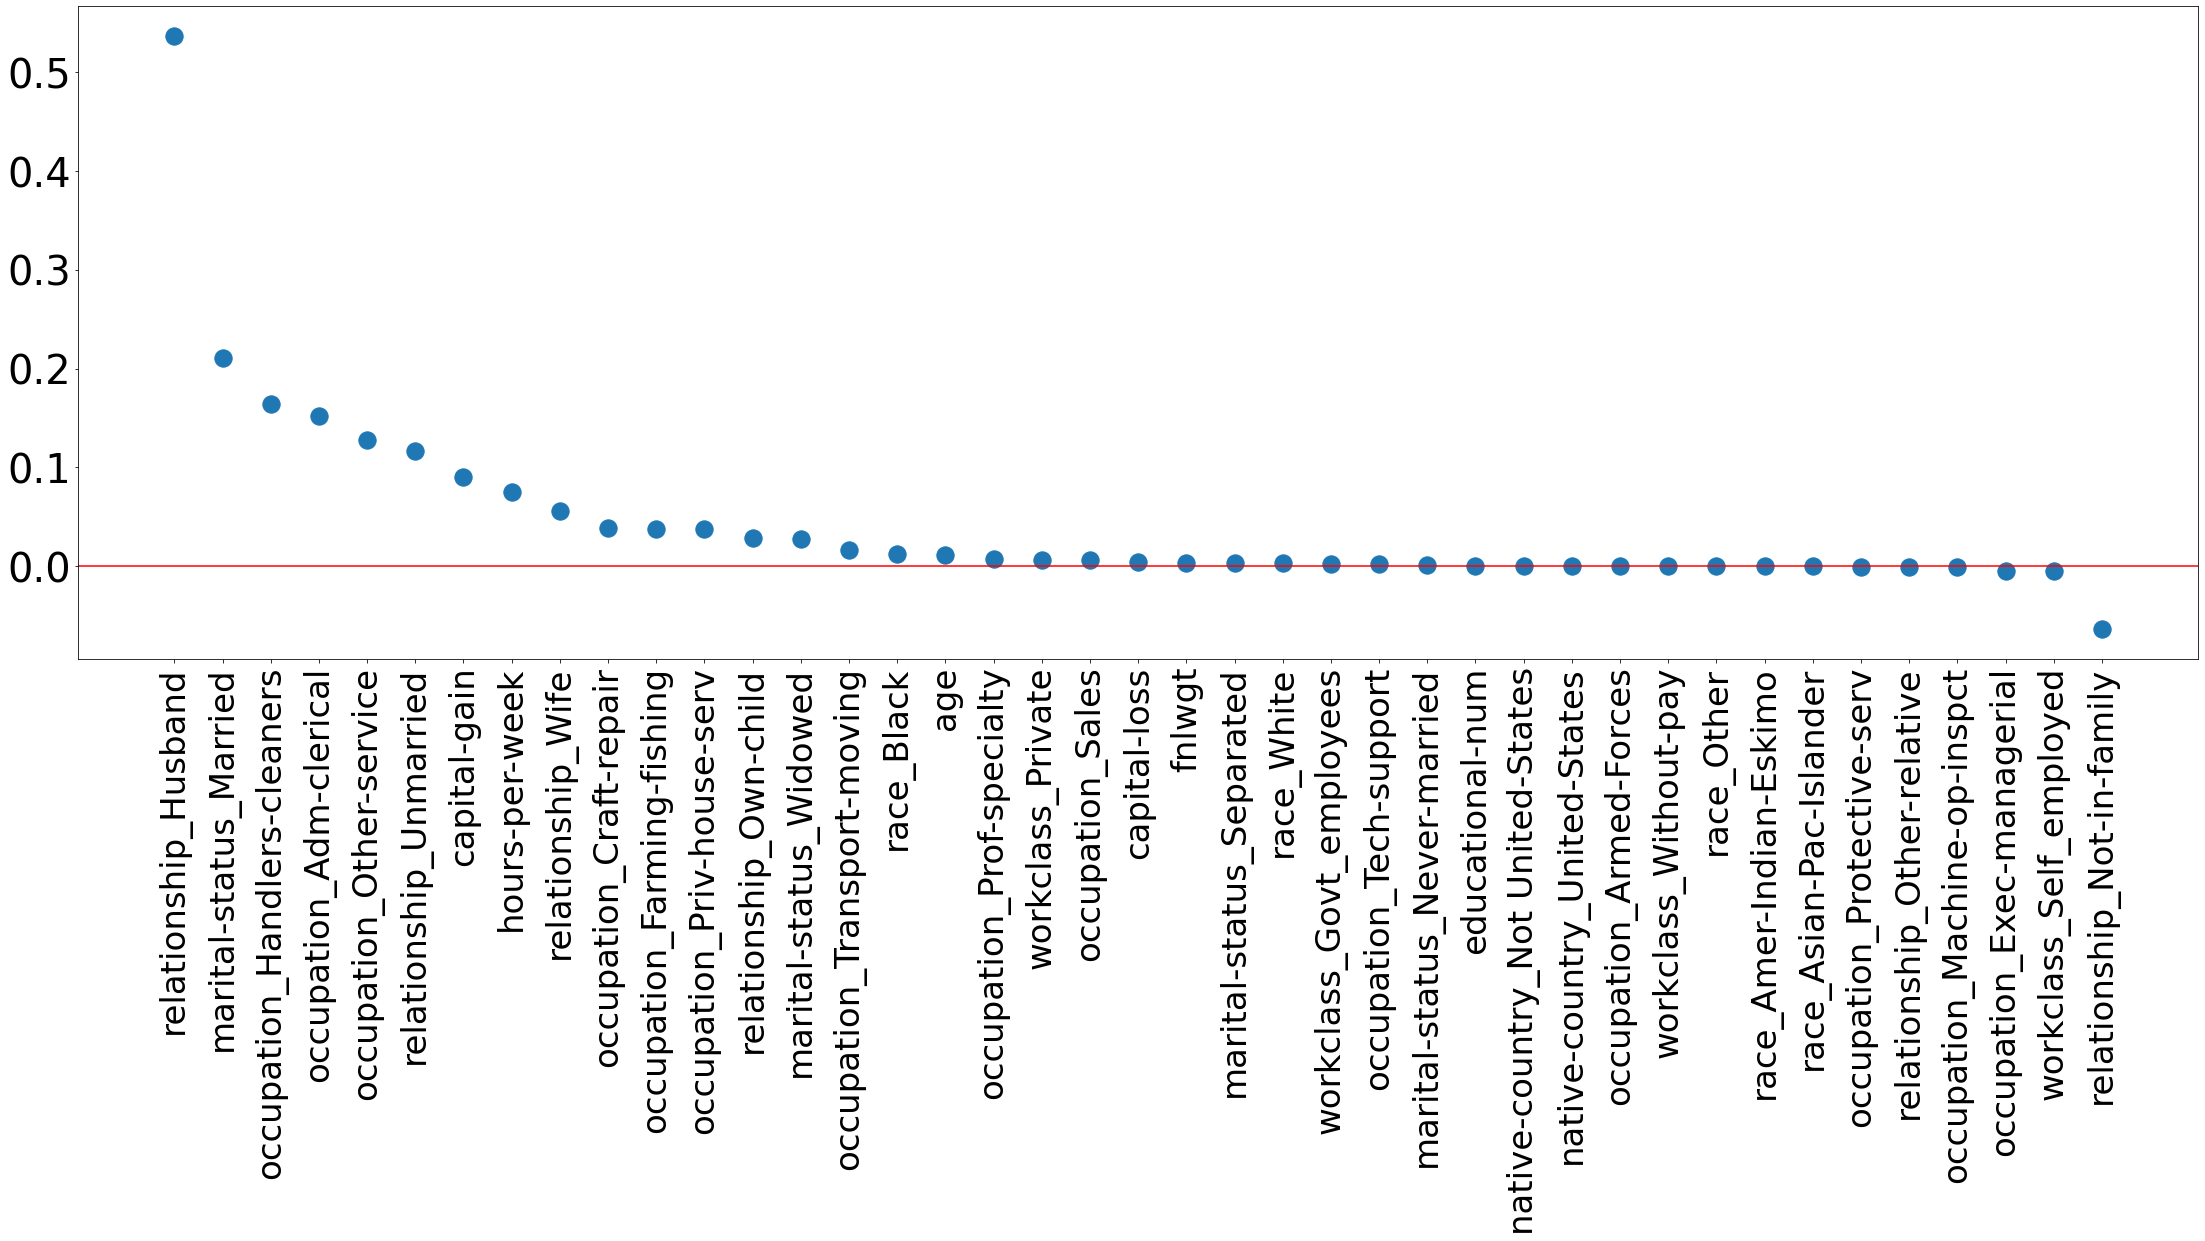

In [95]:
figure, ax = plt.subplots(figsize=(38,12))
ax.scatter(np.array(sorted_diff.index), sorted_diff['feature contribution'], s=300)
xticks_labels = np.array(sorted_diff.index)
plt.yticks(fontsize=32)
ax.set_xticklabels(xticks_labels, rotation=90, fontsize=34)
plt.yticks(fontsize=40)
ax.axhline(y=0, color="red")
plt.show()

We see that there are many similarities between these results and the results from approach 1. For one, both approaches suggest that Relationship:Husband is contributing the most to differences in $p\%$ scores between a model with a high $p\%$ score vs a model with a low $p\%$ score. Furthermore, we see that the second highest contributor to the difference between the fair model and the unfair model is Marital-status:Married, which is similar to approach 1 in that Marital-status:Married exhibited the third highest change in feature influence relative to $p\%$. Lastly, we see that this second approach measures Occupation:Handlers-cleaners, and Occupation:Adm-clerical as having respective feature contributions of 0.173, and 0.152 to the difference in the fair and unfair models. This is similar to the results of our first approach in that Occupation:Handlers-cleaners and Occupation:Adm-clerical were also suggested to have measurable influences in the change in $p\%$ across different models. 